In [137]:
import scipy.io
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
def load_data(file):
    mat = scipy.io.loadmat('heartbeat_data/'+file)
    return mat['val'][0]

Text(0.5, 0, 'electrode 3')

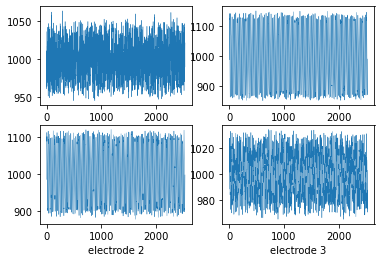

In [139]:
y=load_data('004.mat')
electrode0=y[0]
electrode1=y[1]
electrode2=y[2]
electrode3=y[3]

fig,ax = plt.subplots(2,2)
x=(np.arange(0,len(electrode0)))

ax[0][0].plot(x,electrode0,linewidth=.4)
ax[0][1].plot(x,electrode1,linewidth=.4)
ax[1][0].plot(x,electrode2,linewidth=.4)
ax[1][1].plot(x,electrode3,linewidth=.4)
ax[0][0].set_xlabel('electrode 0')
ax[0][1].set_xlabel('electrode 1')
ax[1][0].set_xlabel('electrode 2')
ax[1][1].set_xlabel('electrode 3')

In [148]:
transformer = FastICA(whiten='unit-variance')
y_transposed = y.T
y_transformed = transformer.fit_transform(y_transposed)
y_beats = []
for row in y_transformed.T:
    if min(row)< -0.05 or max(row)>0.05:
        # flip sign
        if abs(np.min(row)) > abs(np.max(row)):
            row = row * -1
            y_beats.append(row)
y_beats = np.asarray(y_beats)

print(y_beats.shape)

(2, 2523)


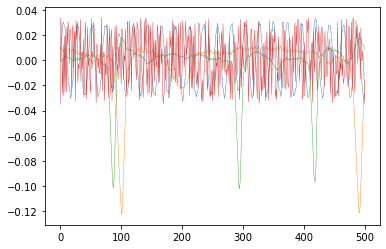

In [151]:
N=500

x2=(np.arange(0,N))

signal1=np.array([y_transformed.T[0][i] for i in range(N)])
signal2=np.array([y_transformed.T[1][i] for i in range(N)])
signal3=np.array([y_transformed.T[2][i] for i in range(N)])
signal4=np.array([y_transformed.T[3][i] for i in range(N)])

plt.plot(x2,signal1,linewidth=.4)
plt.plot(x2,signal2,linewidth=.4)
plt.plot(x2,signal3,linewidth=.4)
plt.plot(x2,signal4,linewidth=.4)
plt.show()

In [154]:
#separating heartbeats
first_beats = scipy.signal.find_peaks(y_beats[0], height=0.05)
print(first_beats)
second_beats = scipy.signal.find_peaks(y_beats[1], height=0.05)
print(second_beats)
fetus =  y_beats[1] if first_beats[0].shape[0] > second_beats[0].shape[0] else y_beats[1]

(array([ 101,  490,  882, 1288, 1697, 2087, 2480], dtype=int64), {'peak_heights': array([0.12329936, 0.12168496, 0.12310822, 0.11730971, 0.1172621 ,
       0.10660275, 0.11935281])})
(array([  87,  294,  417,  528,  743,  963, 1087, 1289, 1480, 1620, 1734,
       1967, 2151, 2267, 2380, 2479], dtype=int64), {'peak_heights': array([0.10198343, 0.10266777, 0.09660608, 0.10101058, 0.10191319,
       0.10210912, 0.10232506, 0.09208522, 0.09983595, 0.09940987,
       0.09764071, 0.08524241, 0.08430195, 0.09664906, 0.09105082,
       0.08534381])})


In [155]:
#fetal information
fetal_info= first_beats if first_beats[0].shape[0] > second_beats[0].shape[0] else second_beats
fetal_spike_time=fetal_info[0]
fetal_amplitude=fetal_info[1]['peak_heights']
print(fetal_amplitude)
print(fetal_spike_time)

[0.10198343 0.10266777 0.09660608 0.10101058 0.10191319 0.10210912
 0.10232506 0.09208522 0.09983595 0.09940987 0.09764071 0.08524241
 0.08430195 0.09664906 0.09105082 0.08534381]
[  87  294  417  528  743  963 1087 1289 1480 1620 1734 1967 2151 2267
 2380 2479]


In [156]:
def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    cuttoff=3 # 68% -1 , 95% -2 , 99.7% -3
    anomaly_cut_off = data_std * cuttoff
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies



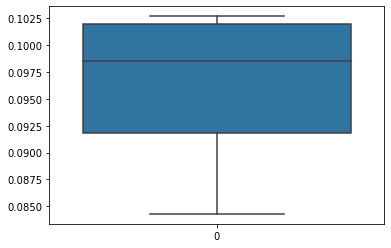

In [157]:
#detecting irregularities in data 
#,amplitudes

sns.boxplot(data=fetal_amplitude)
anomaly1=find_anomalies(fetal_amplitude)
if anomaly1!=[]:
    print("irregular heartbeat")
    print(anomaly1)
    


In [158]:
#detecting irregularities in data 
#,peak_width
n=fetal_spike_time.shape[0]
peak_width_diff=[np.abs(fetal_spike_time[i]-fetal_spike_time[i+1]) for i in range(n-5)]


#sns.boxplot(data=peak_width_diff)
anomaly2=find_anomalies(peak_width_diff)
if anomaly2!=[]:
    print("irregular heartbeat")
    print(anomaly2)
    

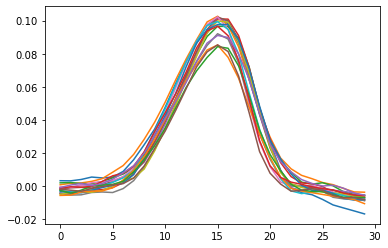

In [159]:
m=30
x=(np.arange(0,m))
spikes=[]
for p in fetal_spike_time:
    current_spike=[]
    for i in range(int(p-m/2),int(p+m/2)):
        current_spike.append(fetus[i])
    spikes.append(current_spike)
    plt.plot(x,current_spike)


In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(spikes)

In [132]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

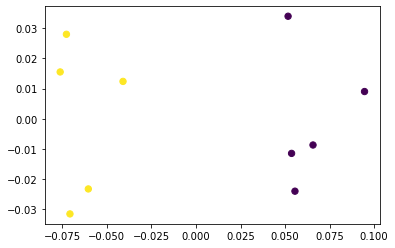

In [133]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

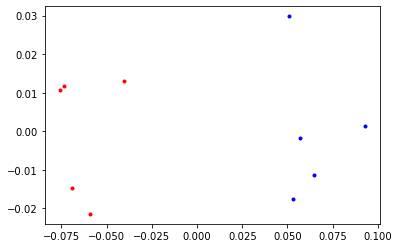

In [134]:
fig,ax = plt.subplots()
plt.plot(principalComponents[:,0][kmeans.labels_==1],principalComponents[:,1][kmeans.labels_==1],'.r',label='Neuron 1')
plt.plot(principalComponents[:,0][kmeans.labels_==0],principalComponents[:,1][kmeans.labels_==0],'.b',label='Neuron 0')

In [ ]:
#Dont think clustering will work here

In [135]:
a=5
b=4
print(a,b)

5 4
